<a href="https://colab.research.google.com/github/1y33/Deep-Learning/blob/main/Fashion_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project description

This is my first project where I create and CNN from scratch based of a tinyvgg architecture

The project is made for educational purposes

NOTE: The confussion matrix in the project is after one epoch in the training loop, if you decide to run it for more epochs the confussion matrix will be better

In [3]:
import torch
import matplotlib.pyplot as plt
from torch import nn
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from mlxtend.plotting import plot_confusion_matrix
from tqdm.auto import tqdm

!pip install -q torchmetrics
from torchmetrics import ConfusionMatrix



BATCH_SIZE=32

device="cuda" if torch.cuda.is_available else "cpu"

## Creating the data

In [4]:
train_data=datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None

)

test_data=datasets.FashionMNIST(
    root="data",
    download=True,
    transform=ToTensor(),
    target_transform=None
)


train_dataloader=DataLoader(
    dataset=train_data,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_dataloader=DataLoader(
    dataset=test_data,
    batch_size=BATCH_SIZE,
    shuffle=True
)


class_names = train_data.classes

100%|██████████| 26421880/26421880 [00:02<00:00, 10464272.54it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 179493.26it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3229920.94it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 5799698.36it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



## Creating the model

In [5]:
from torch import nn
class cnn_model (nn.Module):
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
      nn.Conv2d(in_channels=input_shape,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1),
      nn.ReLU(),
      nn.Conv2d(in_channels=hidden_units,
                out_channels=hidden_units*2,
                kernel_size=3,
                stride=1,
                padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2)
    )
    self.conv_block_2 = nn.Sequential(
      nn.Conv2d(in_channels=hidden_units*2,
                out_channels=hidden_units*2,
                kernel_size=3,
                stride=1,
                padding=1),
      nn.ReLU(),
      nn.Conv2d(in_channels=hidden_units*2,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2)
    )
    self.classifier = nn.Sequential(
      nn.Flatten(),
      nn.Linear(in_features=hidden_units*7*7,
                out_features=output_shape)
    )

  def forward(self, x):
    x = self.conv_block_1(x)
    x = self.conv_block_2(x)
    x = self.classifier(x)
    return x


model=cnn_model(input_shape=1,
              output_shape=10,
              hidden_units=32).to(device)

## Training and testing loop + optimizer and loss function

In [7]:
loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(params=model.parameters(),
                          lr=0.1)
torch.manual_seed(36)
epochs=1
for epoch in range(epochs):
  train_loss=0
  for batch , (X,y) in enumerate(train_dataloader):
    X,y=X.to(device),y.to(device)
    model.train()
    y_pred=model(X)
    loss=loss_fn(y_pred,y)
    train_loss+=loss
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  train_loss/=len(train_dataloader)

  test_loss=0
  model.eval()
  with torch.inference_mode():
    for batch, (X,y) in enumerate(test_dataloader):
      X,y=X.to(device),y.to(device)
      y_test_pred=model(X)
      test_loss+=loss_fn(y_test_pred,y)

    test_loss/=len(test_dataloader)

  print(f"\nEpoch:{epoch}\nTrain loss: {train_loss:.5f}| Test Loss {test_loss:.5f}")


Epoch:0
Train loss: 0.25204| Test Loss 0.21670


## Creating predictions

In [8]:
model.eval()
y_preds = []

with torch.inference_mode():
  for batch, (X, y) in tqdm(enumerate(test_dataloader)):
    X, y = X.to(device), y.to(device)
    y_pred_logits = model(X)
    y_pred_labels = torch.argmax(torch.softmax(y_pred_logits, dim=1), dim=1)
    y_preds.append(y_pred_labels)
  y_preds=torch.cat(y_preds).cpu()

0it [00:00, ?it/s]

## Creating Confussion Matrix

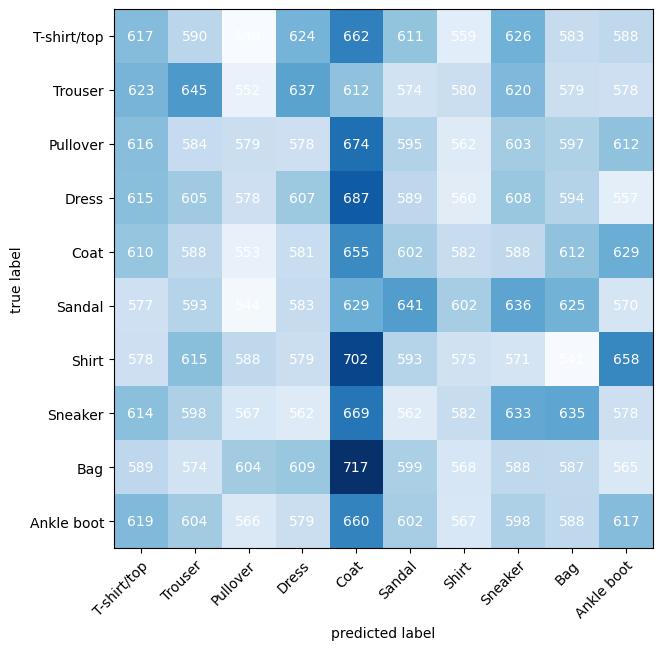

In [9]:
confmat = ConfusionMatrix(task="multiclass", num_classes=len(class_names))
confmat_tensor = confmat(preds=y_preds,
                         target=test_data.targets)

fix, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names=class_names,
    figsize=(10, 7)
)